---
# **データマイニング特別演習　演習テーマ1**
## **【埼玉大学における電力使用量削減策の提案】開講期間前期における空き教室の変動を最小化することによる電力使用への影響に関する考察**
---

In [1]:
# ライブラリの読み込み
# %pip install --upgrade pip
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install openpyxl
# %pip install sympy
# %pip install scipy
# %pip install re
# %pip install jaconv
# %pip install scikit-learn
# %pip install statsmodels
# %pip install seaborn
# %pip install pmdarima
# %pip install kneed
# %pip install requests
# %pip install beautifulsoup4
# %pip install selenium
# %pip install pdfplumber
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='seaborn')
warnings.filterwarnings("ignore", category=DeprecationWarning)
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import sympy as sp
import scipy.stats as stats
import re
import jaconv 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import itertools
import matplotlib.dates as mdates
import pmdarima as pm
from IPython.display import clear_output
from sklearn.metrics import r2_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import time
from matplotlib.ticker import LogLocator, LogFormatter
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
# from selenium.webdriver.edge.options import Options
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.select import Select
from selenium.webdriver.common.action_chains import ActionChains
import pdfplumber
from collections import defaultdict
from selenium.common.exceptions import NoSuchElementException

### 1. 背景
　埼玉大学の電力使用を削減することを考え，まず第一に思いついたことが，時限ごとに空き教室となる場所が変わることが多いという問題である．具体例を挙げれば，1時限目では教室Aで授業があり教室Bは空き教室であるとして，それが2時限目では逆転している事があるということがある．実体験として，4時限目の講義で教室が暑いということもよくあった．この空き教室の変動をなくせれば，電力使用を削減できるのではないかと考えた．

### 2. 目的
　今回は，埼玉大学にある教室をすべて把握する必要があり，[それに関するデータ](https://www.saitama-u.ac.jp/society/lease/schoolroom/pricelist.pdf)を見つけたため，まずこのデータのクローリングを行う．
　次に，[シラバス検索](https://syllabus.risyu.saitama-u.ac.jp/syllabus/campussquare.do?_flowExecutionKey=_c3BB30963-3E3B-5BF8-35F3-68E6739AFBC3_kC11BBD7E-CD3C-6507-9CBB-86EBD187BDD5)を用いて埼玉大学の前期に開講される講義の時限と教室の情報をスクレイピングし，教室の使用状況を確認する．
　最後に，空き教室の変動を最小化した場合，電力使用がどの程度減少し，結果としていくらの削減になるのか概算する．

#### 3. 埼玉大学における教室情報のクローリング
　[教室一覧に関するデータ](https://www.saitama-u.ac.jp/society/lease/schoolroom/pricelist.pdf)のクローリングを行う．

In [15]:
# URLで指定したPDFファイルを取得
url = 'https://www.saitama-u.ac.jp/society/lease/schoolroom/pricelist.pdf'
res = requests.get(url)

# PDFファイルとして保存
with open('pricelist.pdf', 'wb') as f:
    f.write(res.content)

# PDFの構造をそのまま出力
with pdfplumber.open('pricelist.pdf') as pdf:
    for page_num, page in enumerate(pdf.pages, start=1):
        print(f"Page {page_num}")
        print("="*40)
        
        # ページ内のテキストとその位置を取得
        for obj in page.extract_words():
            print(f"Text: {obj['text']}, Position: ({obj['x0']}, {obj['top']})")

        print("\n")

# y座標の上限を指定
y_threshold = 102.8364
data = []

with pdfplumber.open('pricelist.pdf') as pdf:
    for page_num, page in enumerate(pdf.pages, start=1):
        text_by_line = defaultdict(list)
        
        # 各テキストの位置情報を取得し、指定されたy以下のものだけを抽出
        for obj in page.extract_words():
            if obj['top'] >= y_threshold:
                text_by_line[round(obj['top'], 1)].append((obj['x0'], obj['text']))

        # 各行を`y`位置でソートし、同じ行内のテキストを左から右に並べる
        for y_position, items in sorted(text_by_line.items()):
            # x座標でソートして列順を確定
            sorted_items = sorted(items, key=lambda x: x[0])
            line_text = [text for _, text in sorted_items]
            data.append(line_text)

# タイトル行を定義・追加
columns = ["教室名", "-", "室名", "-", "面積", "座席数", "-", "-", "-", "-", "-", "-"]
df = pd.DataFrame(data, columns=columns)

#講義室ではないと思われる教室を除去（ラウンジなど）
df = df.drop(columns=["-"])
df['座席数'] = pd.to_numeric(df['座席数'], errors='coerce')
df = df[df['座席数'] <= 300]

df.to_csv("教室データベース.csv", index=False, header=True)
display(df)

Page 1
Text: 教室一覧及び貸付料金表, Position: (250.08, 22.479600000000005)
Text: 令和5年4月1日現在, Position: (297.36, 33.71640000000002)
Text: 表示料金は消費税抜きの金額です。, Position: (297.36, 43.076400000000035)
Text: 空調機器は自由に使用できます（原則、光熱水料を含む）。, Position: (297.36, 52.19640000000004)
Text: 面積, Position: (191.16, 63.71640000000002)
Text: 収容人数, Position: (226.92, 63.71640000000002)
Text: 4～6月、10～11月, Position: (313.08, 63.2364)
Text: 7～9月、12～3月, Position: (406.56, 63.2364)
Text: 建物名, Position: (38.4, 75.35640000000001)
Text: 階, Position: (82.56, 75.35640000000001)
Text: 室名, Position: (116.4, 75.35640000000001)
Text: 試験での, Position: (156.24, 75.35640000000001)
Text: ㎡, Position: (194.64, 75.35640000000001)
Text: 座席数, Position: (215.52, 75.35640000000001)
Text: 試験座席, Position: (242.4, 74.99039999999991)
Text: 段差の, Position: (273.0, 75.35640000000001)
Text: 4時間まで, Position: (304.44, 75.35640000000001)
Text: 4時間超, Position: (352.08, 75.35640000000001)
Text: 4時間まで, Position: (395.88, 75.35640000000001)
Text: 4時間超, Posit

,教室名,室名,面積,座席数
0,全学講義棟１号館,201講義室,88㎡,61.0
1,全学講義棟１号館,202講義室,88㎡,61.0
2,全学講義棟１号館,203講義室,117㎡,129.0
3,全学講義棟１号館,204講義室,59㎡,41.0
4,全学講義棟１号館,205講義室,154㎡,162.0
...,...,...,...,...
108,総合研究棟,12番講義室,180㎡,154.0
109,総合研究棟,セミナー室５,42㎡,36.0
110,総合研究棟,セミナー室６,42㎡,36.0
111,総合研究棟,セミナー室７,42㎡,36.0


　以上より，教室のデータベースが作成できた．

### 4. 講義名・時限・教室の対応関係についてスクレイピング
　[埼玉大学教務システムシラバス検索ページ](https://syllabus.risyu.saitama-u.ac.jp/syllabus/)より，埼玉大学において前期に開講される講義に関してシラバス検索を行い，講義名・時限・教室の対応関係をスクレイピングする．

In [16]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# URLで指定したWebページを取得
url = 'https://syllabus.risyu.saitama-u.ac.jp/syllabus/'

try:
    res = requests.get(url)
    res.raise_for_status()  # HTTPエラーがあれば例外を発生
    # HTMLを行ごとに分割して出力
    for i, line in enumerate(res.text.splitlines(), start=1):
        print(f'{i:04}: {line.strip()}')  # 行番号を付けて表示
except requests.exceptions.RequestException as e:
    print(f"Error fetching the URL: {e}")

# Chromeの設定
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(options=options)
driver.set_window_size(1280, 900)
driver.get(url)
time.sleep(1)

# 全講義の探索
list_yobi = ['月', '火', '水', '木', '金', '土', '日']
list_jigen = ['1', '2', '3', '4', '5', '6', '7']

kikan_list = [] # 開講期間リスト
day_list = []   # 曜日時限リスト
class_list = [] # 講義名リスト
room_list = []  # 教室名リスト
url_list = []   # URLリスト

for kikan in ['第1', '第2', '第1・2']:
    for yobi in list_yobi:
        for jigen in list_jigen:
            # 前期の講義のみに設定
            dropdown_1 = driver.find_element(By.CSS_SELECTOR, '#kaikoKbnCd')
            select_1 = Select(dropdown_1)
            select_1.select_by_visible_text(kikan)
            time.sleep(1)

            # 曜日の設定
            dropdown_2 = driver.find_element(By.CSS_SELECTOR, '#yobi')
            select_2 = Select(dropdown_2)
            select_2.select_by_visible_text(f'{yobi}曜日')
            time.sleep(1)

            # 時限の設定
            dropdown_3 = driver.find_element(By.CSS_SELECTOR, '#jigen')
            select_3 = Select(dropdown_3)
            select_3.select_by_visible_text(f'{jigen}限')
            time.sleep(1)

            # 表示の設定
            dropdown_4 = driver.find_element(By.NAME, "_displayCount")
            select_4 = Select(dropdown_4)
            select_4.select_by_value("200")
            time.sleep(1)

            # 「検索」をクリック
            search_button = driver.find_element(By.CSS_SELECTOR, "#jikanwariKeywordForm > table > tbody > tr:nth-child(11) > td > p > input:nth-child(1)")
            search_button.click()
            time.sleep(1)

            # 検索結果がなかった場合
            if driver.find_elements(By.CSS_SELECTOR, '#jikanwariKeywordForm > span'):
                continue # 要素が存在しない場合にスキップ

            # 検索結果の数を取得
            result_number = driver.find_element(By.CSS_SELECTOR, '#jikanwariKeywordForm > div > b:nth-child(4)').text
            result_number = int(re.sub(r'件目', '', result_number))
            time.sleep(1)

            for _no in range(result_number):
                try:
                    # 講義名を取得
                    _class = driver.find_element(By.CSS_SELECTOR, f'#jikanwariKeywordForm > div > table > tbody > tr:nth-child({_no + 1}) > td:nth-child(4)').text
                    time.sleep(1)

                    # シラバスのリンクを取得
                    syllabus_url = driver.find_element(By.CSS_SELECTOR, f'#jikanwariKeywordForm > div > table > tbody > tr:nth-child({_no + 1}) > td:nth-child(6) > input:nth-child(1)').get_attribute('onclick')
                    time.sleep(1)

                    # URLの解析
                    syllabus_url = re.search(r"'(.*?)'", syllabus_url).group(1)
                    syllabus_url = f"https://syllabus.risyu.saitama-u.ac.jp{syllabus_url}"
                    driver.get(syllabus_url)
                    time.sleep(1)

                    # 教室名を取得
                    _room = driver.find_element(By.CSS_SELECTOR, '#tabs-1 > table > tbody > tr:nth-child(11) > td').text
                    _room = _room.split("／")[0]  # ／以降の英語は消去
                    time.sleep(1)

                    # 開講期間／曜日・時限を追加
                    _day = f'{yobi}{jigen}'

                    # ブラウザバック
                    driver.back()
                    time.sleep(1)

                    # 結果の出力
                    class_list.append(_class)
                    kikan_list.append(kikan)
                    day_list.append(_day)
                    room_list.append(_room)
                    url_list.append(syllabus_url)
                    print(f'{_class}: {kikan}, {_day}, {_room}, {syllabus_url}')

                except NoSuchElementException:

                    # ブラウザバック
                    driver.back()
                    time.sleep(1)
                    
                    continue  # 要素が存在しない場合にスキップ

            # ブラウザバック
            driver.back()
            time.sleep(1)

# データを辞書型に変換しデータフレーム化
data = {
    '講義名': class_list,
    '開講期間': kikan_list,
    '曜日・時限': day_list,
    '講義室': room_list,
    'URL': url_list
}
df = pd.DataFrame(data)
df.to_csv('講義データベース.csv', index=False)
display(df)

driver.quit()

0001: 
0002: 
0003: 
0004: 
0005: 
0006: 
0007: 
0008: 
0009: 
0010: 
0011: 
0012: 
0013: <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN"
0014: "http://www.w3.org/TR/html4/loose.dtd">
0015: 
0016: <html>
0017: 
0018: 
0019: 
0020: 
0021: <head>
0022: <meta name="viewport" content="width=device-width, initial-scale=1.0"/>
0023: <meta charset="UTF-8">
0024: <meta http-equiv="X-UA-Compatible" content="IE=Edge" />
0025: 
0026: 
0027: <meta http-equiv="Cache-Control" content="no-cache">
0028: <meta http-equiv="Pragma" content="no-cache">
0029: <meta http-equiv="Expires" content="Thu, 01 Dec 1994 16:00:00 GMT">
0030: 
0031: 
0032: 
0033: <meta name="format-detection" content="telephone=no">
0034: 
0035: 
0036: <link rel="SHORTCUT ICON" href="/syllabus/theme/default/image/favicon.ico">
0037: 
0038: 
0039: <title>シラバス検索</title>
0040: 
0041: 
0042: 
0043: <link type="text/css" rel="stylesheet" href="/syllabus/static/pub/jquery-core/3.4.1/themes/smoothness/theme.css" />
0044: <scr

,講義名,開講期間,曜日・時限,講義室,URL
0,初等社会科概説 第1ターム、小（社・音・図・体）・副2年以上,第1,月1,遠隔授業,https://syllabus.risyu.saitama-u.ac.jp/syllabu...
1,経済原論 第１ターム（2023年度以前入学者：マルクス経済学）,第1,月1,経-B201,https://syllabus.risyu.saitama-u.ac.jp/syllabu...
2,特殊講義「数理統計特講」 第１ターム,第1,月1,経-A405,https://syllabus.risyu.saitama-u.ac.jp/syllabu...
3,科学技術英語 月１・水１の週２回授業,第1,月1,工-31,https://syllabus.risyu.saitama-u.ac.jp/syllabu...
4,水圏防災減災工学 月１・水１の週２回授業,第1,月1,工-32,https://syllabus.risyu.saitama-u.ac.jp/syllabu...
...,...,...,...,...,...
2159,経済政策論,第1・2,土2,東京ＳＣ,https://syllabus.risyu.saitama-u.ac.jp/syllabu...
2160,ミクロ経済学,第1・2,土3,東京ＳＣ,https://syllabus.risyu.saitama-u.ac.jp/syllabu...
2161,産業連関分析,第1・2,土4,東京ＳＣ,https://syllabus.risyu.saitama-u.ac.jp/syllabu...
2162,アジアの少子化,第1・2,土5,東京ＳＣ,https://syllabus.risyu.saitama-u.ac.jp/syllabu...


以上より，概ね理想的なデータベースが得られたことが確認できた．

### 5. 現状の教室使用状況を可視化
　曜日・時限と講義室の表を作り，空き教室であれば白，講義があれば赤，複数の講義がある場合は青でセルを塗り，使用状況を可視化する．

複数該当: 開講期間=第1, 講義室=コモ棟教育学第２演習室, 曜日・時限=水4
  - 教育学演習 IG
  - 教育学演習 IIIＧ
複数該当: 開講期間=第1, 講義室=コモ棟教育学第３演習室, 曜日・時限=木4
  - 教育学演習 IE
  - 教育学演習 IIIＥ
複数該当: 開講期間=第1, 講義室=コモ棟３０９講義室, 曜日・時限=木5
  - 子どもの保健Ａ　Y60130と同時限
  - 小児保健学　Y38610と同時限
複数該当: 開講期間=第1, 講義室=全学講義棟 1-202, 曜日・時限=木4
  - 演習Ⅰ　第１ターム
  - 演習Ⅳ　第１ターム
複数該当: 開講期間=第1, 講義室=全学講義棟 1-202, 曜日・時限=木5
  - 演習Ⅰ　第１ターム
  - 演習Ⅳ　第１ターム
複数該当: 開講期間=第1, 講義室=全学講義棟 1-204, 曜日・時限=月1
  - 日本語B(総合) a
  - 日本語B(漢字) a
複数該当: 開講期間=第1, 講義室=全学講義棟 1-204, 曜日・時限=火4
  - 研究科目「日本政治史」　第１ターム、3年生以上履修可
  - 日本政治史
複数該当: 開講期間=第1, 講義室=全学講義棟 1-204, 曜日・時限=火5
  - 研究科目「日本政治史」　第１ターム、3年生以上履修可
  - 日本政治史
複数該当: 開講期間=第1, 講義室=全学講義棟 1-204, 曜日・時限=木4
  - 演習Ⅰ　第１ターム
  - 演習Ⅳ　第１ターム
複数該当: 開講期間=第1, 講義室=全学講義棟 1-204, 曜日・時限=木5
  - 演習Ⅰ　第１ターム
  - 演習Ⅳ　第１ターム
複数該当: 開講期間=第1, 講義室=全学講義棟 1-302, 曜日・時限=木4
  - 演習Ⅰ　第１ターム
  - 演習Ⅳ　第１ターム
複数該当: 開講期間=第1, 講義室=全学講義棟 1-302, 曜日・時限=木5
  - 演習Ⅰ　第１ターム
  - 演習Ⅳ　第１ターム
複数該当: 開講期間=第1, 講義室=全学講義棟 1-303, 曜日・時限=火4
  - 演習Ⅰ　第１ターム
  - 演習Ⅳ　第１ターム
複数該当: 開講期間=第1, 講義室=全学講義棟 1-303, 曜日・時限=火5
  - 演習Ⅰ　第１ターム
  - 演習

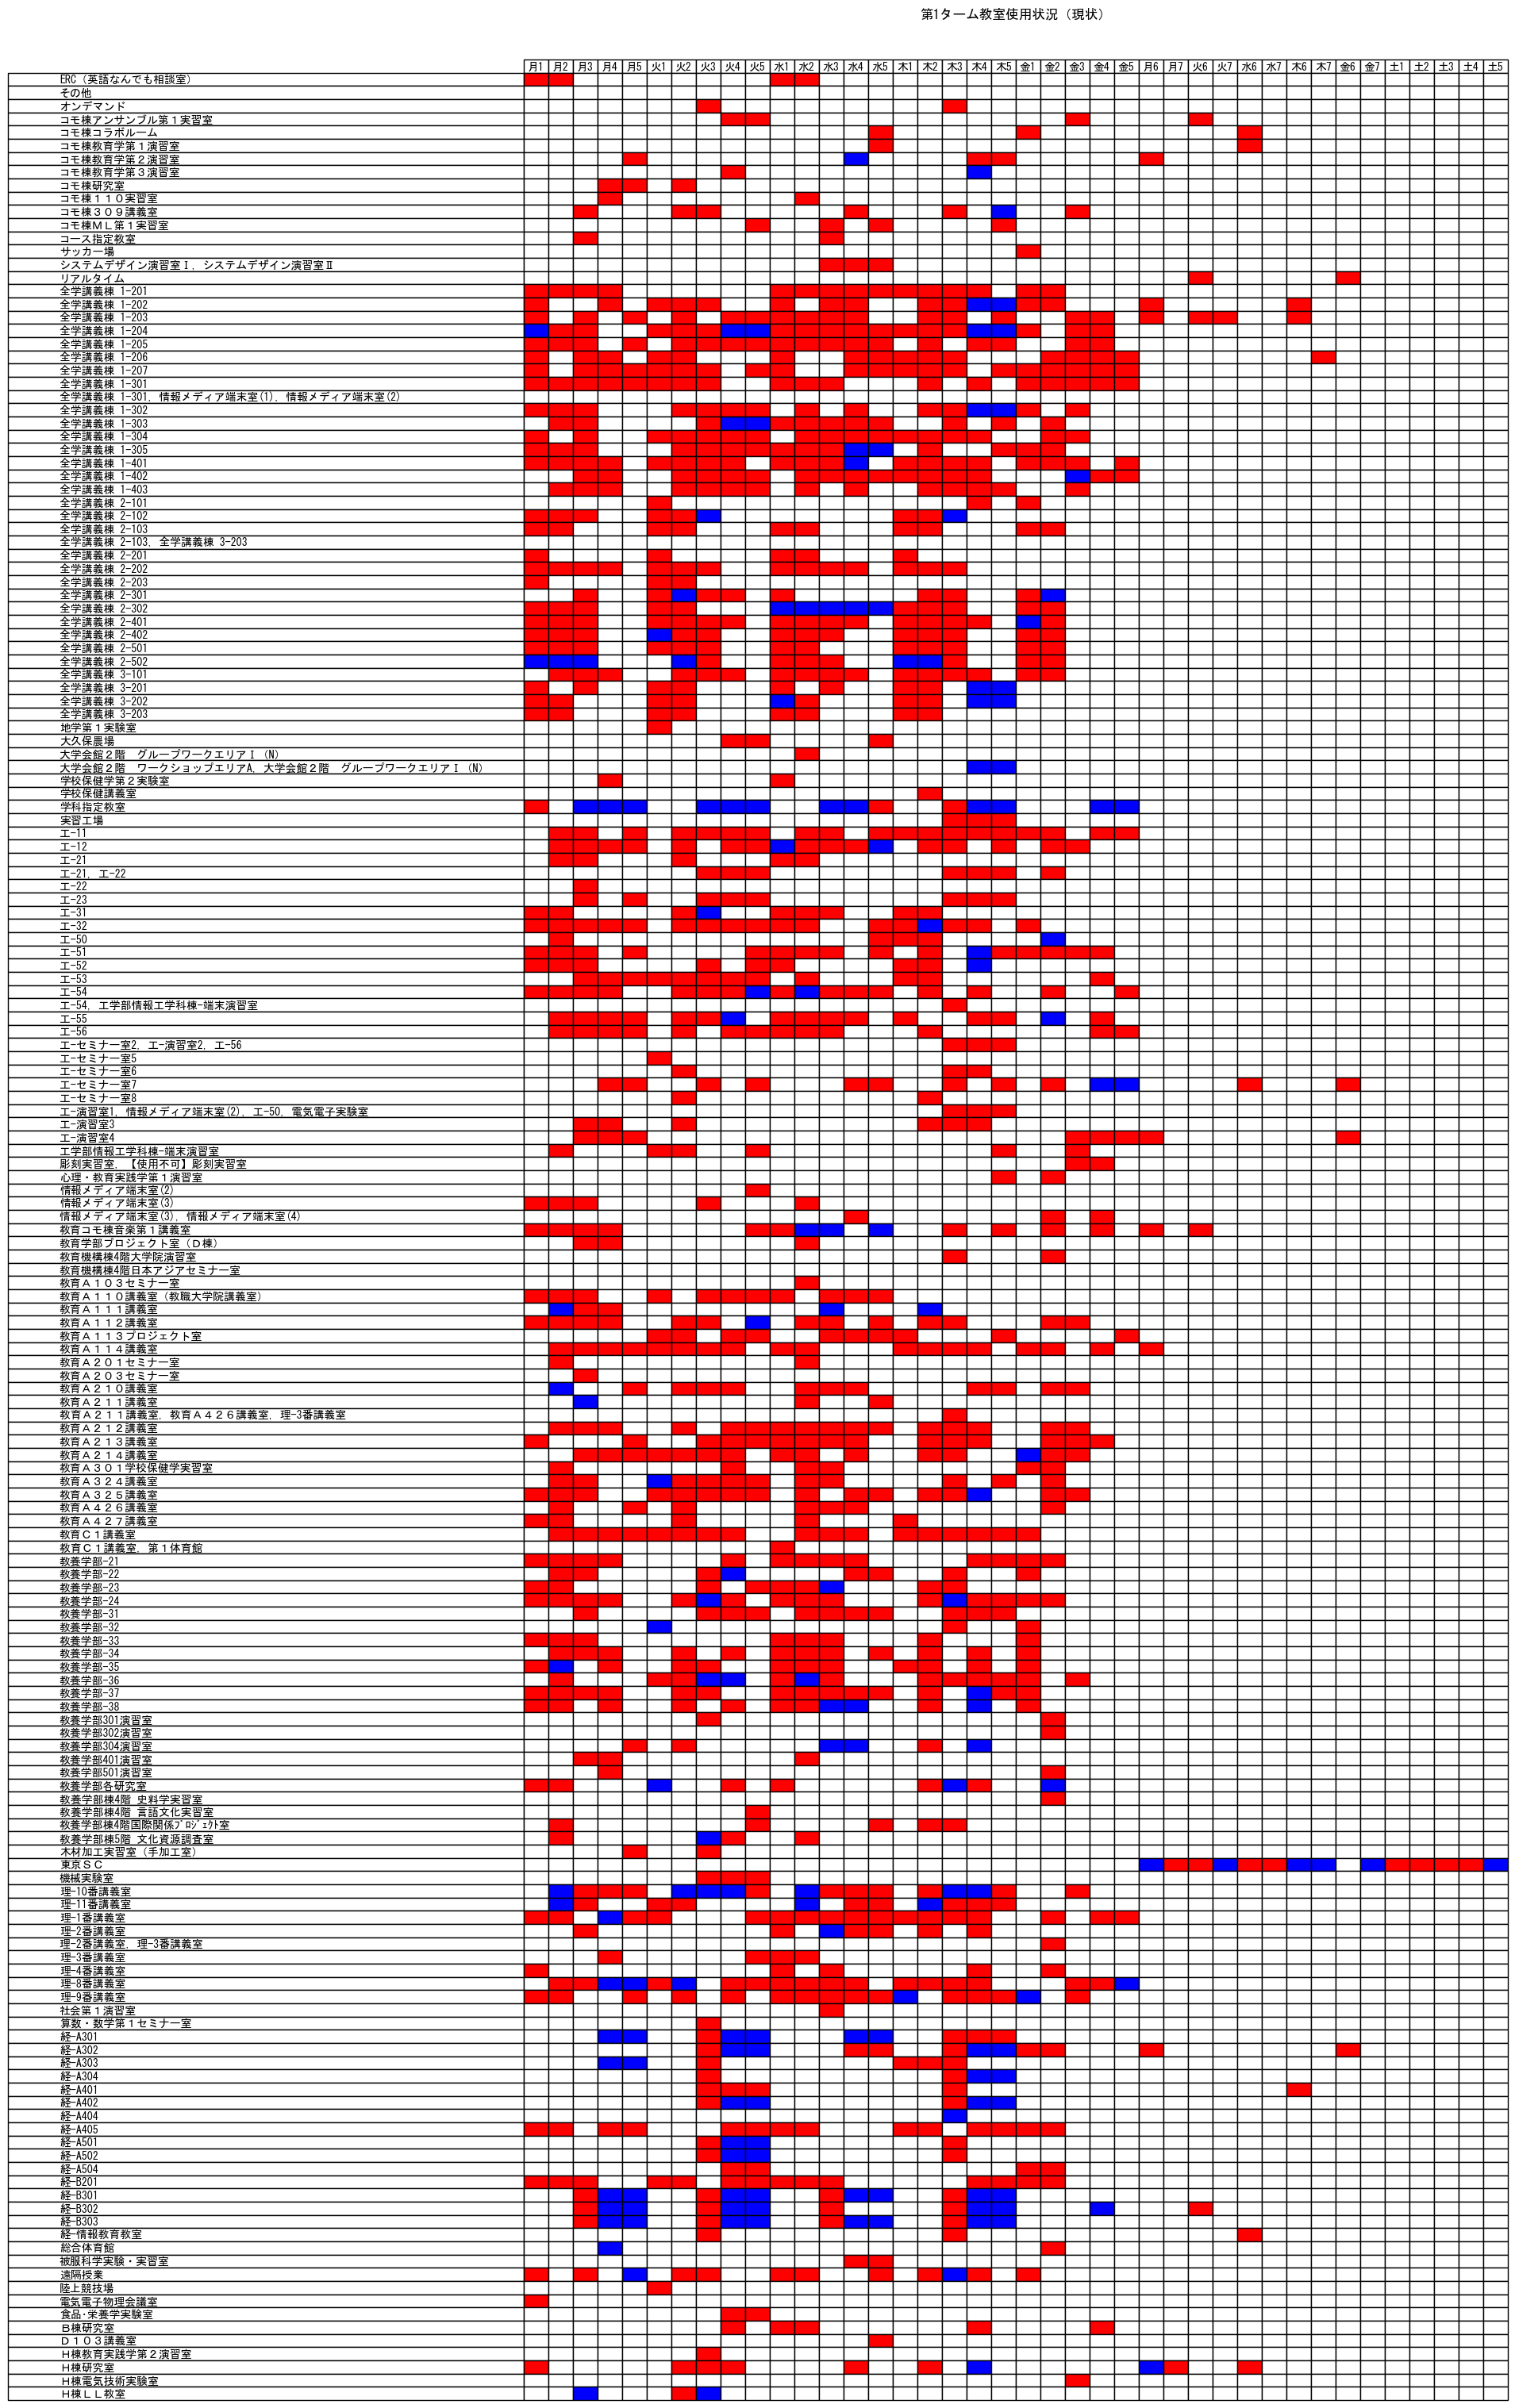

複数該当: 開講期間=第2, 講義室=全学講義棟 1-202, 曜日・時限=木4
  - 演習Ⅱ　第２ターム
  - 演習Ⅴ　第２ターム
複数該当: 開講期間=第2, 講義室=全学講義棟 1-202, 曜日・時限=木5
  - 演習Ⅱ　第２ターム
  - 演習Ⅴ　第２ターム
複数該当: 開講期間=第2, 講義室=全学講義棟 1-204, 曜日・時限=月1
  - 日本語B(総合) b
  - Japanese Language-B(Summer Program)
複数該当: 開講期間=第2, 講義室=全学講義棟 1-204, 曜日・時限=月2
  - 日本語B(総合) b
  - Japanese Language-B(Summer Program)
複数該当: 開講期間=第2, 講義室=全学講義棟 1-204, 曜日・時限=火1
  - 日本語B(総合) b
  - Japanese Language-B(Summer Program)
複数該当: 開講期間=第2, 講義室=全学講義棟 1-204, 曜日・時限=火2
  - 日本語B(総合) b
  - Japanese Language-B(Summer Program)
複数該当: 開講期間=第2, 講義室=全学講義棟 1-204, 曜日・時限=水1
  - 日本語B(総合) b
  - Japanese Language-B(Summer Program)
複数該当: 開講期間=第2, 講義室=全学講義棟 1-204, 曜日・時限=水2
  - 日本語B(総合) b
  - Japanese Language-B(Summer Program)
複数該当: 開講期間=第2, 講義室=全学講義棟 1-204, 曜日・時限=木1
  - 日本語B(総合) b
  - Japanese Language-B(Summer Program)
複数該当: 開講期間=第2, 講義室=全学講義棟 1-204, 曜日・時限=木2
  - 日本語B(総合) b
  - Japanese Language-B(Summer Program)
複数該当: 開講期間=第2, 講義室=全学講義棟 1-301, 情報メディア端末室(1), 情報メディア端末室(2), 曜日・時限=月1
  - ICT活用の理論と実践　第2ターム、初回授

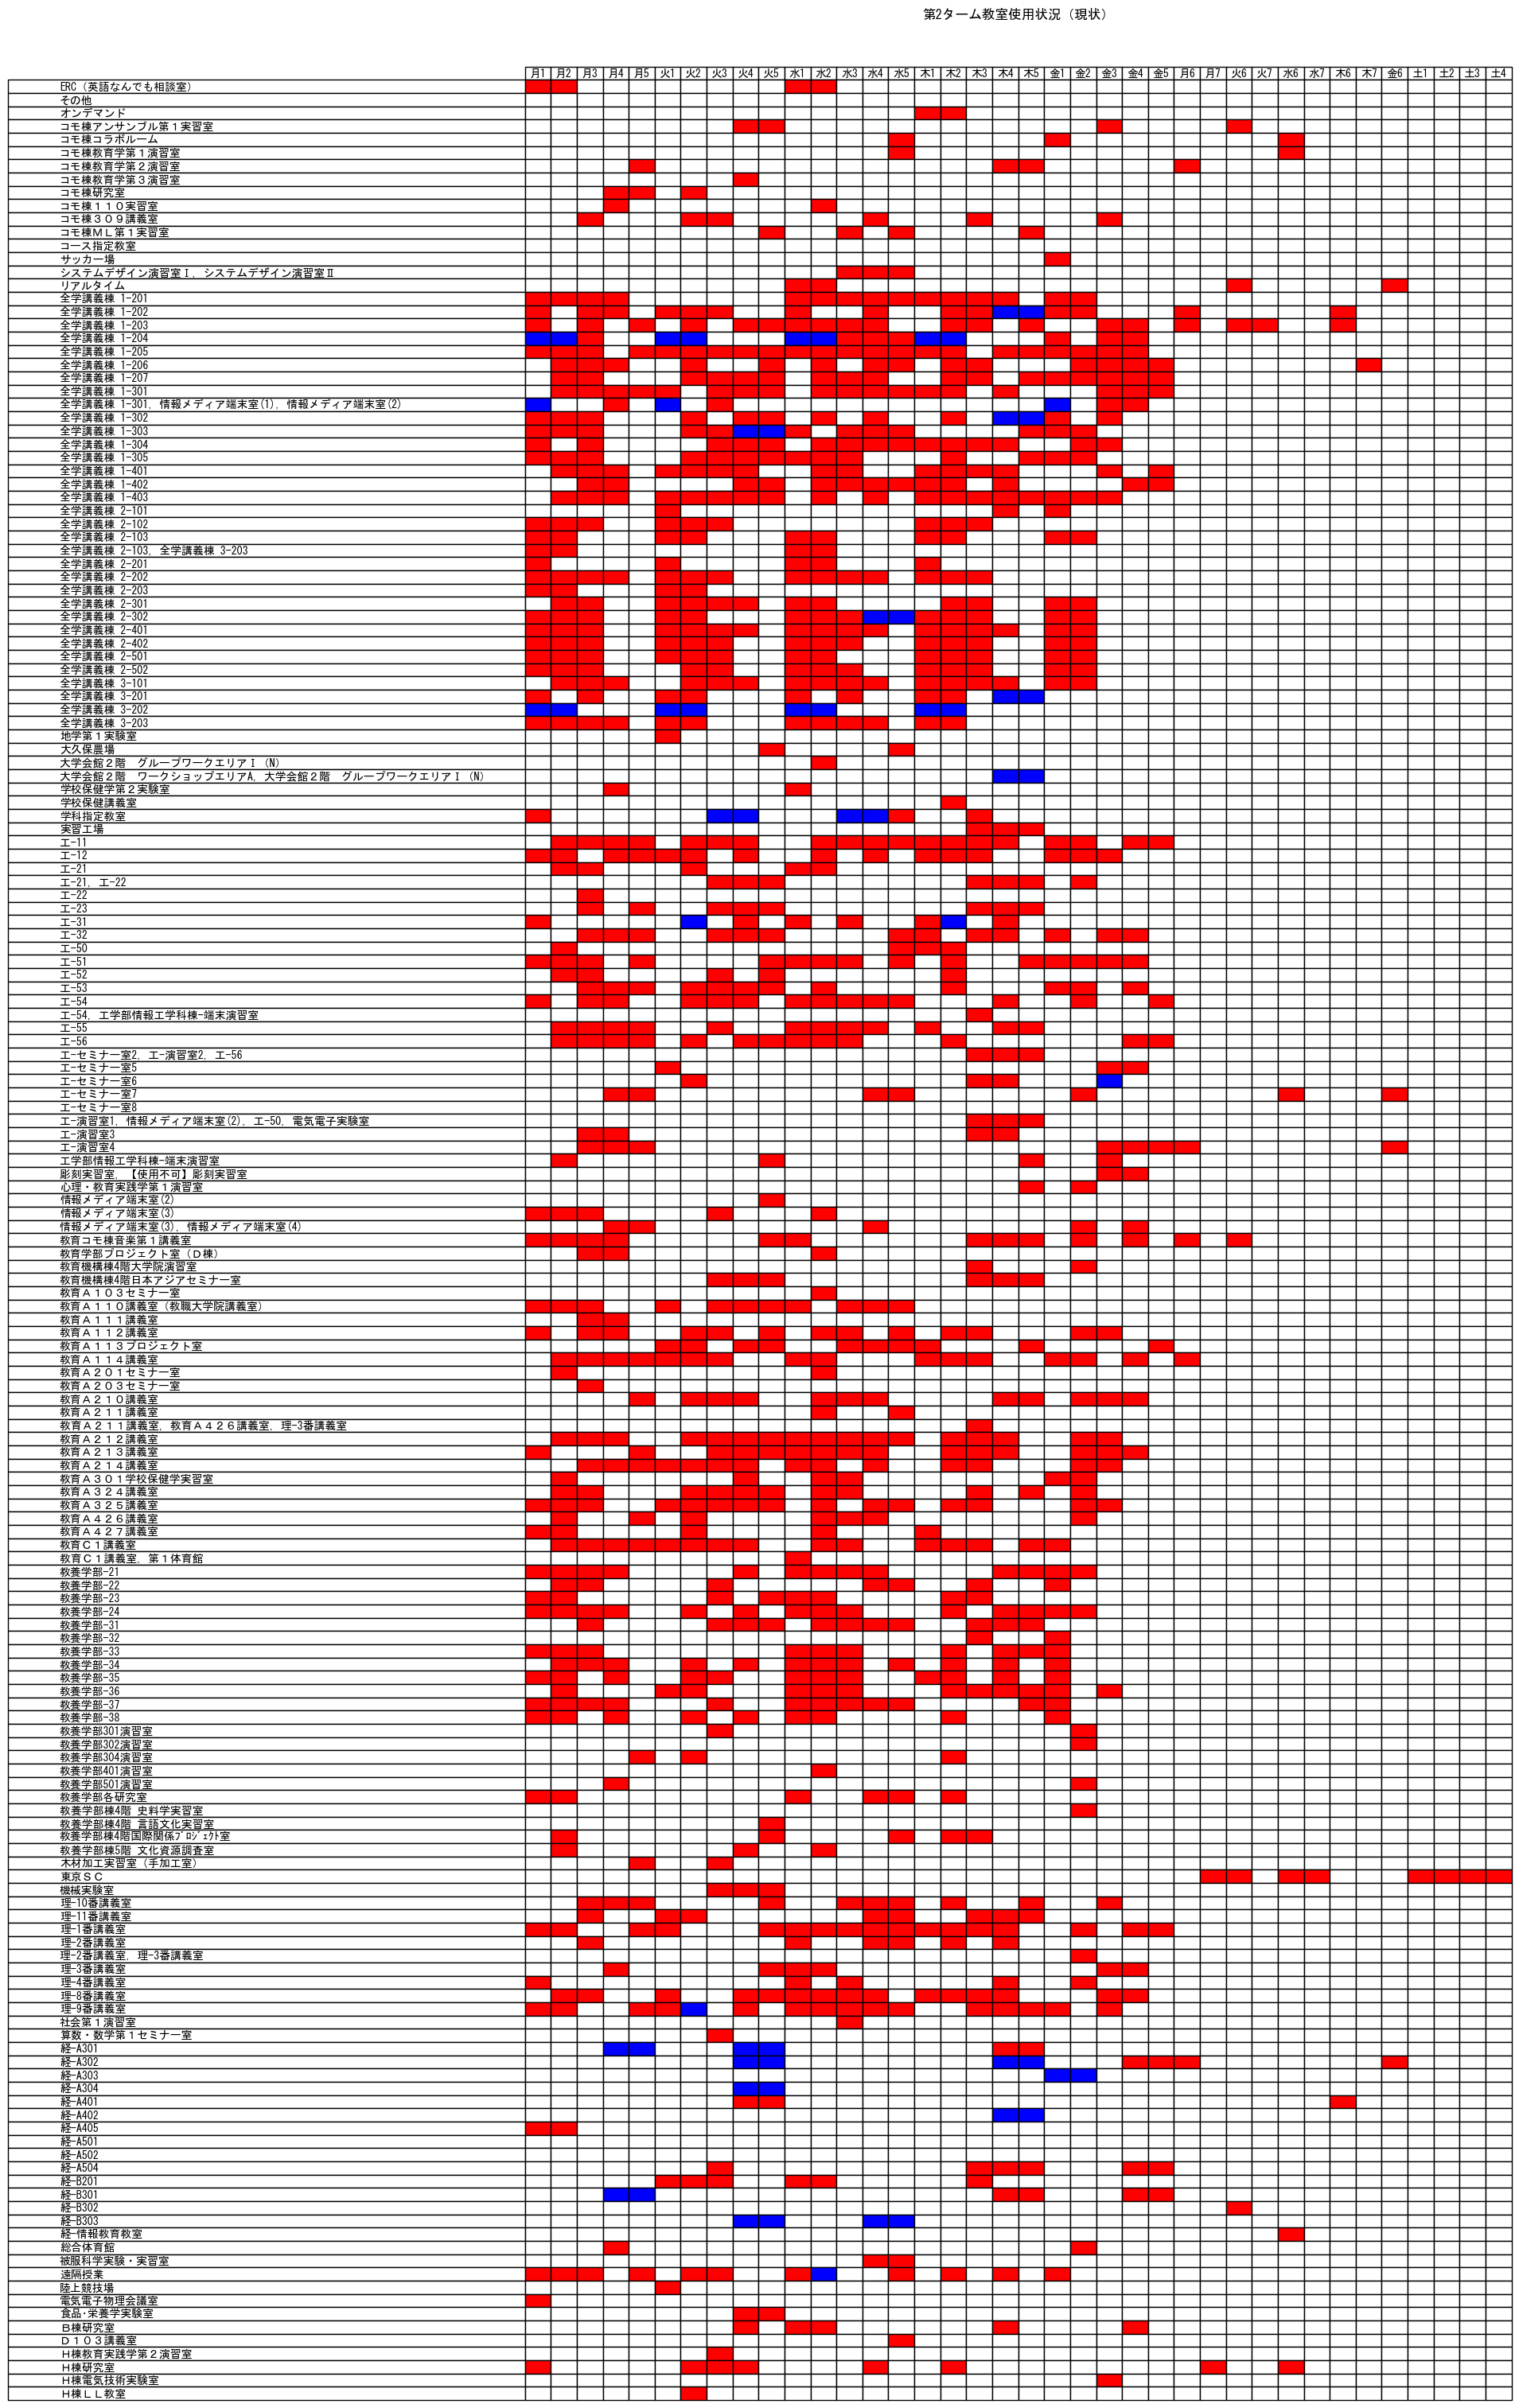

In [21]:
# データベースの読み込み
df = pd.read_csv('講義データベース.csv')

# '第1・第2'を分解し、新しい行を追加する
expanded_rows = []
for _, row in df.iterrows():
    if row['開講期間'] == '第1・2':
        row1 = row.copy()
        row1['開講期間'] = '第1'
        expanded_rows.append(row1)
        row2 = row.copy()
        row2['開講期間'] = '第2'
        expanded_rows.append(row2)
    else:
        expanded_rows.append(row)

# 新しいデータフレームを作成
df = pd.DataFrame(expanded_rows)

# 第1・2タームそれぞれの教室使用状況を可視化
for kikan in ['第1', '第2']:
    # プロットの準備
    plt.rcParams['font.family'] = 'MS Gothic'
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.axis('off')

    # 重複なしの曜日・時限と講義室リストを作成
    row_labels = sorted(df['講義室'].fillna('その他').astype(str).unique().tolist())
    col_labels = df['曜日・時限'].unique().tolist()

    # 表に表示するデータを作成（ここでは空の文字列を設定）
    cell_color_all = []
    for row in row_labels:
        cell_color = []
        for col in col_labels:
            # '講義室'と'曜日・時限'が一致する行を探索
            matching_rows = df[(df['開講期間'] == kikan) & (df['講義室'] == row) & (df['曜日・時限'] == col)]
            
            if len(matching_rows) == 0:
                # 一致するデータがない場合は白
                cell_color.append('#ffffff')
            elif len(matching_rows) == 1:
                # 一致するデータが1つの場合は赤
                cell_color.append('#ff0000')
            else:
                # 一致するデータが複数の場合は青
                cell_color.append('#0000ff')
                print(f"複数該当: 開講期間={kikan}, 講義室={row}, 曜日・時限={col}")
                for lecture in matching_rows['講義名']:
                    print(f"  - {lecture}")
                df = df.drop(matching_rows.index)
        # 列ごとに色を追加
        cell_color_all.append(cell_color)

    # 表の作成
    table = ax.table(cellColours=cell_color_all, rowLabels=row_labels, colLabels=col_labels, cellLoc='center', loc='center')

    # タイトルを設定し、位置を調整
    title = f'{kikan}ターム教室使用状況（現状）'
    plt.title(title, pad=850)  # padでタイトルを上方に移動

    # 画像として保存
    plt.savefig(f'{title}.png', dpi=300, bbox_inches='tight')
    plt.show()


重複があった講義を確認すると，同じ講義を英語版で別に定義されたものであったり，演習系の講義であったりしたため，学科内の事情があるものと判断し例外として扱うこととした．以上より，概ね正しく使用状況を可視化することができた．

### 6. 教室割り当ての改良
　教室はなるべく連続して使われるようにし，空き教室はなるべくそのまま使われないように割り当てることを試みる．当初は部屋の広さなども考慮する予定で教室のデータベースを取得したが，講義のデータベースと表記に揺れがあり，統合作業は手作業になると考えられたため，今回は省略する．

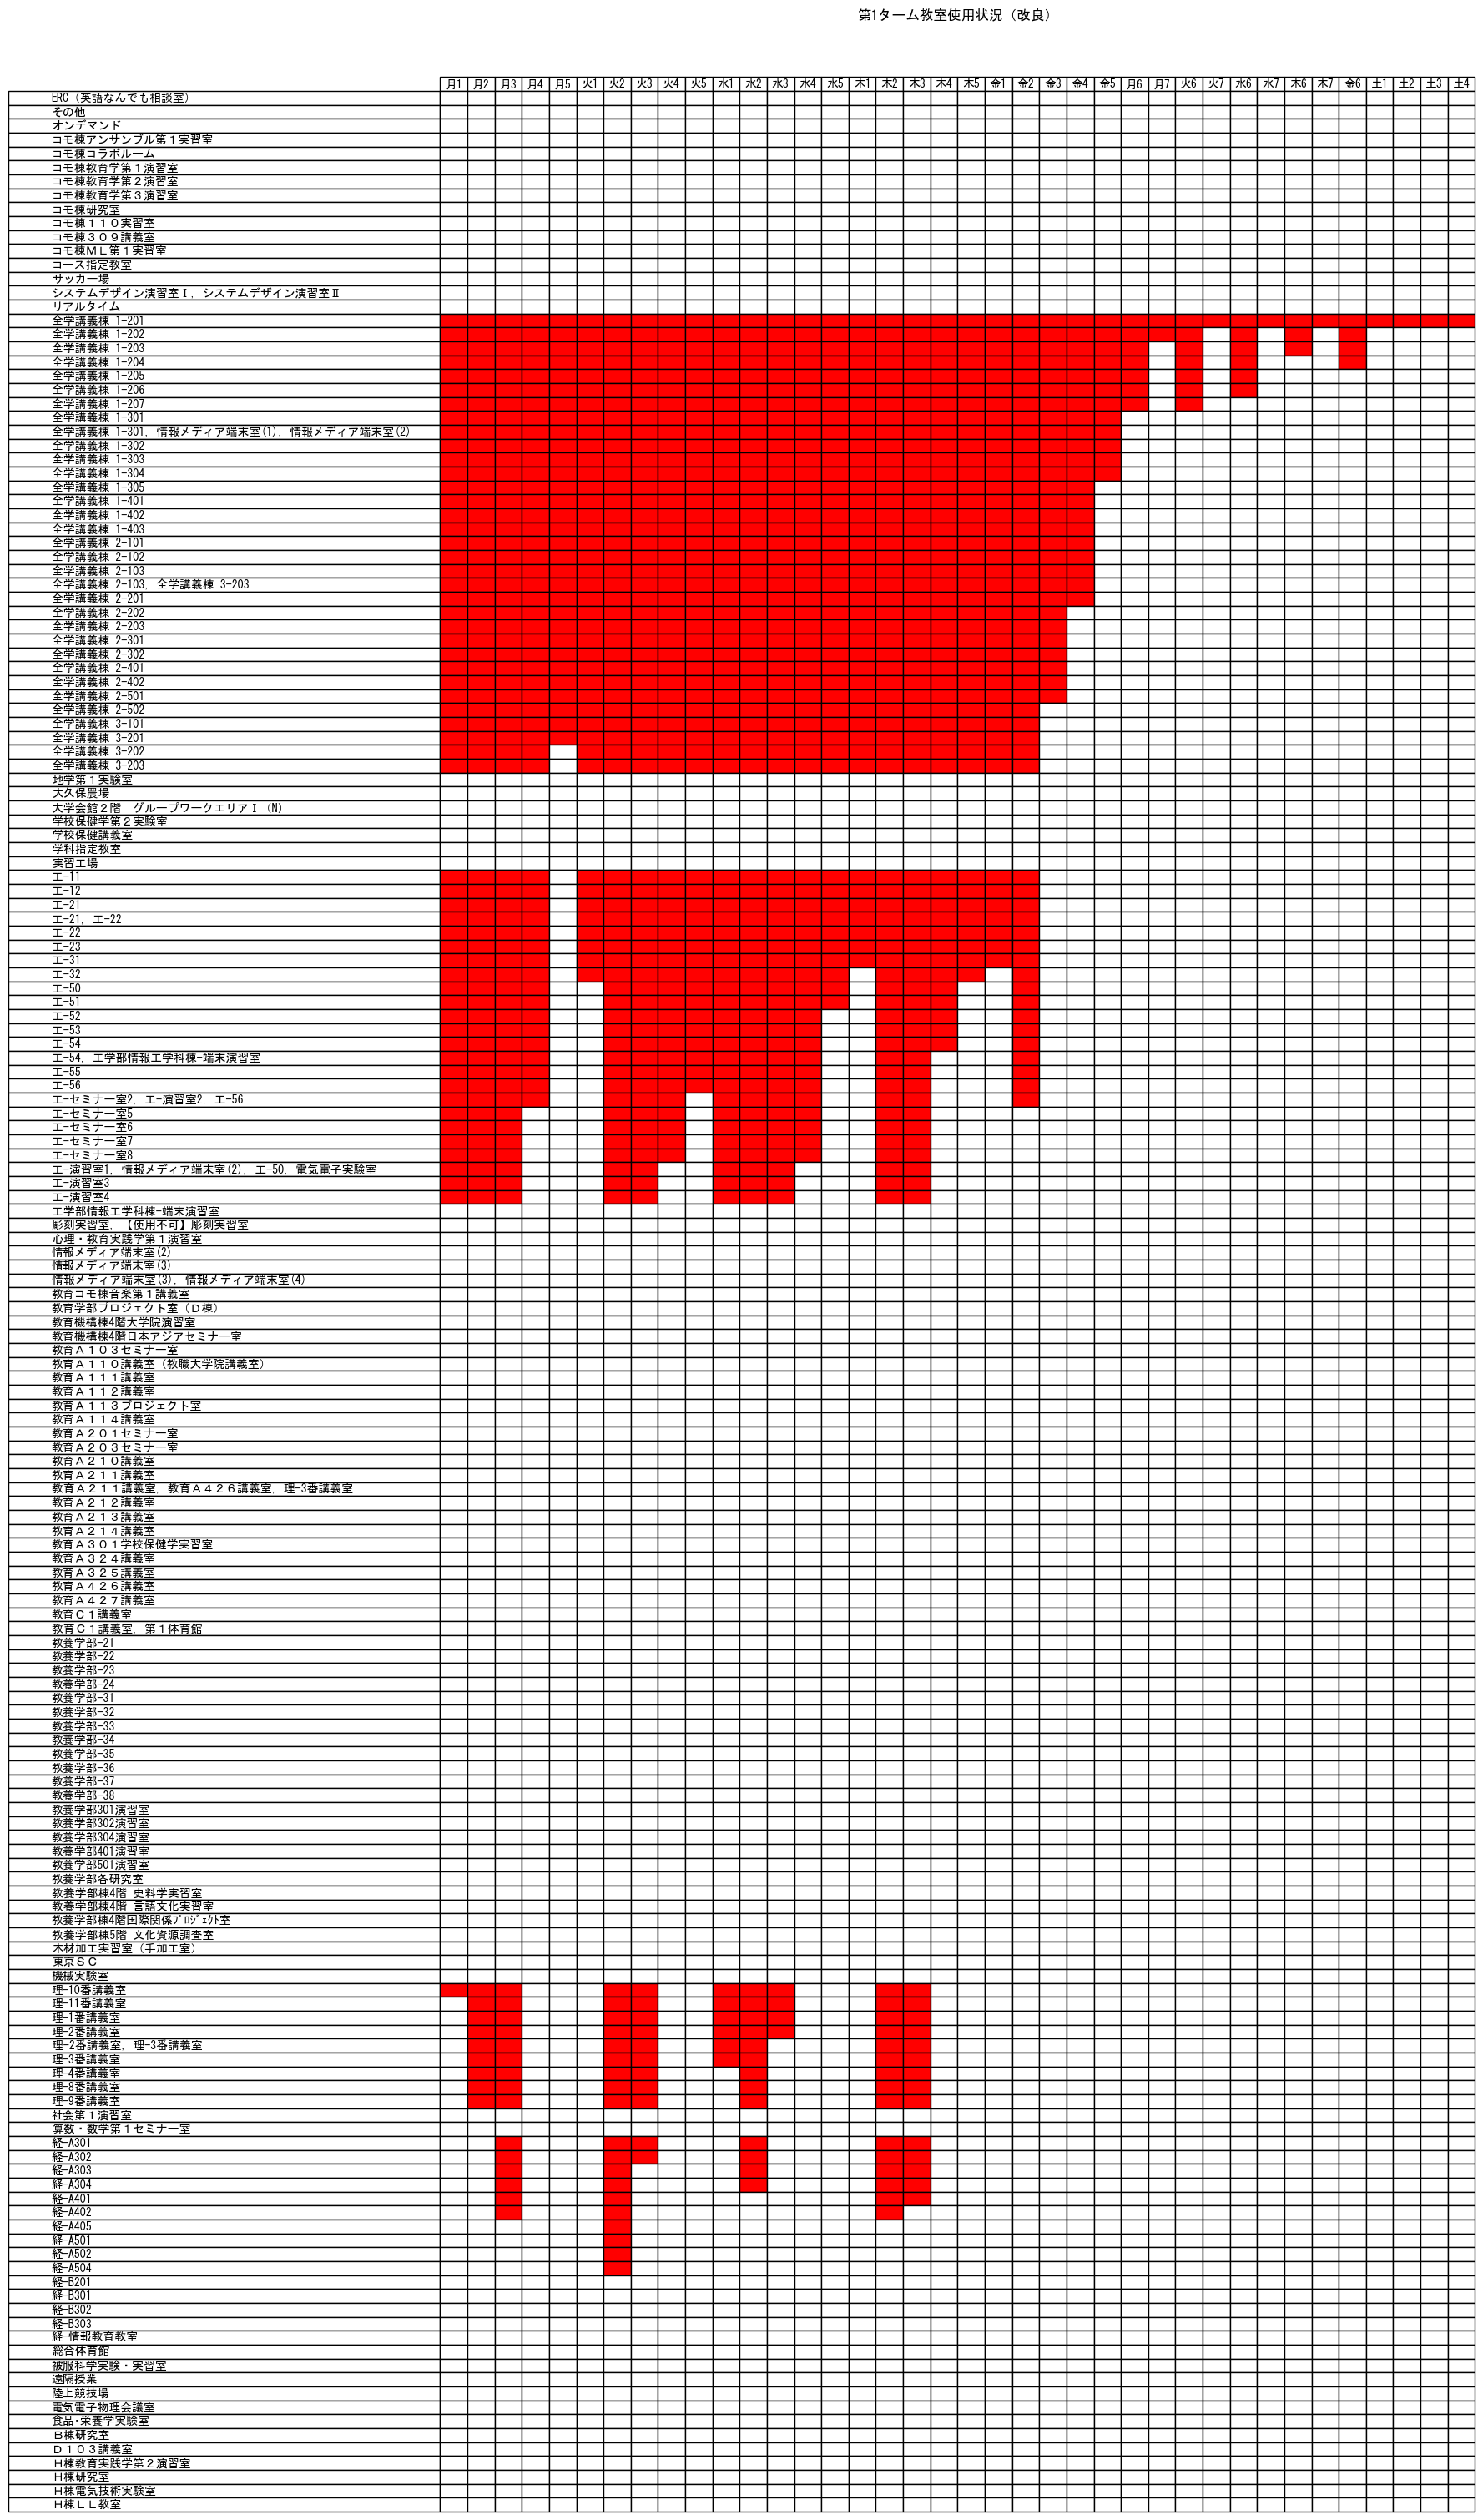

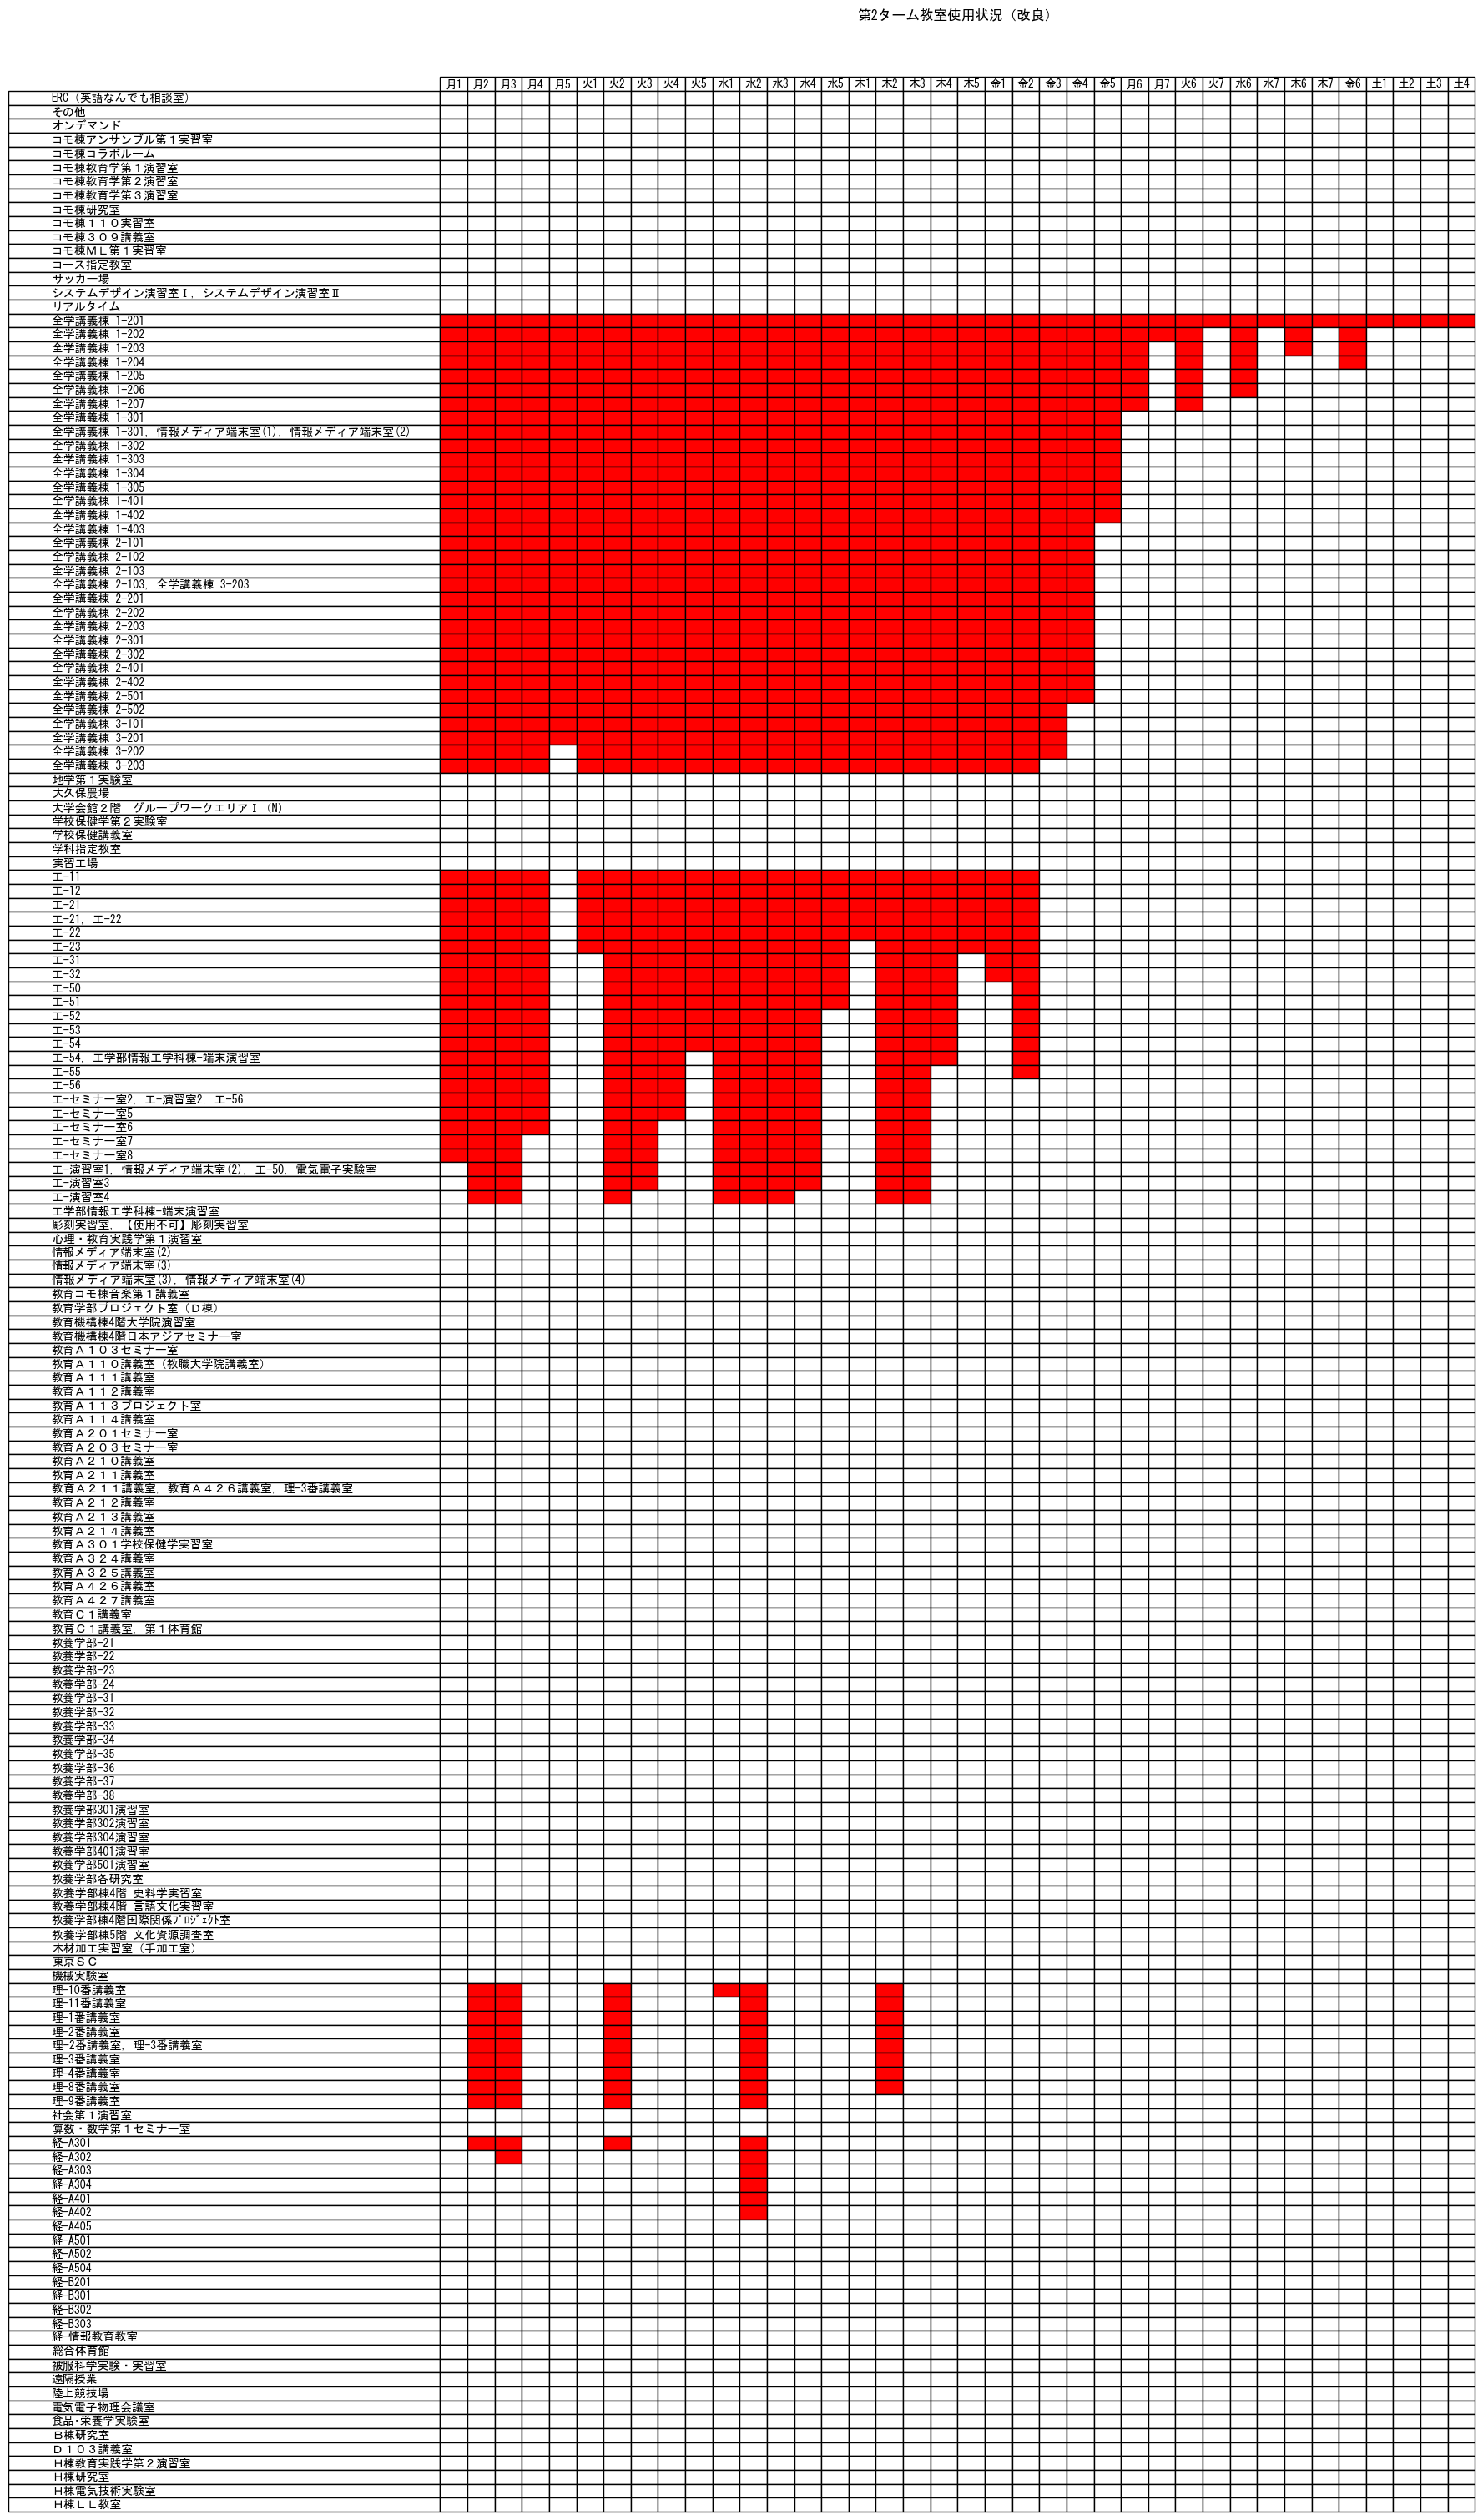

In [22]:
# 全教室のリストを作成
all_rooms = sorted(df['講義室'].fillna('その他').unique().tolist())

# 全学講義棟の教室をリスト化（優先順位用）
zengaku_rooms = [room for room in all_rooms if room.startswith('全学講義棟') or room.startswith('工-') or room.startswith('理-') or room.startswith('経-')]

# 各講義を前の時間帯順に処理するため、データを並べ替える
df['元の順序'] = df.index
df = df.sort_values(by=['開講期間', '曜日・時限', '講義室']).reset_index(drop=True)

# 各時間帯の教室使用状況を記録する辞書
usage_by_timeslot = {}

# 改良後の割り当てリスト
new_assignments = []
for _, row in df.iterrows():
    kikan = row['開講期間']
    timeslot = row['曜日・時限']
    current_room = row['講義室']
    
    # 前の時間帯を取得
    prev_timeslot = str(int(timeslot.split('限')[0]) - 1) + '限' if '限' in timeslot else None
    
    # 現在の時間帯の使用中教室リストを取得または初期化
    if (kikan, timeslot) not in usage_by_timeslot:
        usage_by_timeslot[(kikan, timeslot)] = []

    # 前の時間帯の教室利用状況を確認
    if prev_timeslot and (kikan, prev_timeslot) in usage_by_timeslot:
        prev_usage = usage_by_timeslot[(kikan, prev_timeslot)]
    else:
        prev_usage = []

    # 全学講義棟が空いている場合は優先的に割り当て
    available_zenkaku_rooms = [room for room in zengaku_rooms if room not in usage_by_timeslot[(kikan, timeslot)]]
    
    if available_zenkaku_rooms:
        # 全学講義棟が空いている場合、最初の部屋を割り当て
        selected_room = available_zenkaku_rooms[0]
        usage_by_timeslot[(kikan, timeslot)].append(selected_room)
        new_assignments.append(selected_room)
    elif current_room in prev_usage:
        # 現在の教室が前の時間帯で使用されている場合はそのまま
        usage_by_timeslot[(kikan, timeslot)].append(current_room)
        new_assignments.append(current_room)
    else:
        # 全学講義棟以外の空き教室を検索
        available_rooms = [room for room in all_rooms if room not in usage_by_timeslot[(kikan, timeslot)]]
        
        if available_rooms:
            selected_room = available_rooms[0]  # 空き教室の1つを選択
            usage_by_timeslot[(kikan, timeslot)].append(selected_room)
            new_assignments.append(selected_room)
        else:
            # 空きがない場合、元の教室を割り当て
            usage_by_timeslot[(kikan, timeslot)].append(current_room)
            new_assignments.append(current_room)
            print(f"注意: 開講期間={kikan}, 曜日・時限={timeslot}で利用可能な教室がありません")

# 改良後の教室割り当てをデータフレームに追加
df['講義室（改良）'] = new_assignments
df = df.sort_values(by='元の順序').drop(columns=['元の順序']).reset_index(drop=True)

# 改良後の教室割り当てを可視化して確認
for kikan in ['第1', '第2']:
    # プロットの準備
    plt.rcParams['font.family'] = 'MS Gothic'
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.axis('off')

    # 重複なしの曜日・時限と講義室リストを作成
    row_labels = sorted(df['講義室'].fillna('その他').astype(str).unique().tolist())
    col_labels = df['曜日・時限'].unique().tolist()

    # 表に表示するデータを作成（ここでは空の文字列を設定）
    cell_color_all = []
    for row in row_labels:
        cell_color = []
        for col in col_labels:
            # '講義室'と'曜日・時限'が一致する行を探索
            matching_rows = df[(df['開講期間'] == kikan) & (df['講義室（改良）'] == row) & (df['曜日・時限'] == col)]
            
            if len(matching_rows) == 0:
                # 一致するデータがない場合は白
                cell_color.append('#ffffff')
            elif len(matching_rows) == 1:
                # 一致するデータが1つの場合は赤
                cell_color.append('#ff0000')
            else:
                # 一致するデータが複数の場合は青
                cell_color.append('#0000ff')
                print(f"複数該当: 開講期間={kikan}, 講義室={row}, 曜日・時限={col}")
                for lecture in matching_rows['講義名']:
                    print(f"  - {lecture}")
                df = df.drop(matching_rows.index)
        # 列ごとに色を追加
        cell_color_all.append(cell_color)

    # 表の作成
    table = ax.table(cellColours=cell_color_all, rowLabels=row_labels, colLabels=col_labels, cellLoc='center', loc='center')

    # タイトルを設定し、位置を調整
    title = f'{kikan}ターム教室使用状況（改良）'
    plt.title(title, pad=850)  # padでタイトルを上方に移動

    # 画像として保存
    plt.savefig(f'{title}.png', dpi=300, bbox_inches='tight')
    plt.show()

# CSVに保存
df.to_csv('講義データベース（改良）.csv', index=False)


全学講義棟・工学部講義棟・理学部講義棟・経済学部講義棟に優先的に割り当てを行なった．結果は時間をずらしてもいないのにも関わらず，ほとんどの講義が全学講義棟だけで収まることが可視化された．現実的には，移動が遠かったり，その教室でないとできないことがあったりと，理想通りいかないことは承諾できるが，例えば，工学部は全学講義棟と工学部講義棟優先，教育学部は全学講義棟と教育学部講義棟優先というように決めるなどすれば，ここまで隙間の多い使用状況にはならないと考えられる. また，背景で述べたような違和感はこれが原因であることが示唆される結果となった．

### 7. 改良の前後における電力使用（料金）の概算結果の変化および考察
　電力の概算式は以下のように決定した．まず，温度$T$であった部屋を$T_s$まで下げるのに必要な熱量$Q$は，空気密度$\rho$，部屋の容積$V$，定圧比熱$c_p$を用いて，次式のように表せる．
$$Q=\rho V c_p (T-T_s)$$  
ここで，温度$T_s$まで冷却されて安定するまでにかかる時間は経験則的に0.5時間と見積もり，熱量$Q$の単位を$[\text{kWh}]$とする．
$$Q [\text{kWh}]=0.5 \rho V c_p (T-T_s)$$  
その他のパラメータは，熱力学的知見や経験則を用いて，それぞれ$\rho=1.2[\text{kg/m3}]$，$c_p=1.005[\text{kJ/(kg・K)}]$，$T=35[℃]$，$T_s=24[℃]$と決定した．部屋の容積$V$は，教室データベースの平均値を用いる．エアコンの消費電力$W$は，エアコンの効率 (Coefficient of Performance)$\text{COP}$と使用時間$t[\text{h}]$を用いて，次式のように計算できる． 
$$W [\text{kW}]=\frac{Q t}{\text{COP}}=\frac{1}{12} \rho V c_p (T-T_s) t$$  
エアコンの効率$\text{COP}$は，機種や定格電力によっても変わるが，経験則的にエアコンの効きが弱めであると感じたため，効率は業務用大型エアコンとしては低めの値の6と仮定した．加えて，このままではエアコンの待機電力が考慮されておらず，設定温度に達した時点で消費電力が0となってしまうため，これを補正する．ここでは待機電力を$0.5[\text{kWh}]$と仮定する．
$$W [\text{kW}]=\frac{1}{12} \rho V c_p (T-T_s) t + 0.5t$$   
　料金への換算は講義資料より，1kWあたりの基本料金を1650円，1kWhあたりの電力量料金を23.6円，再生可能エネルギー発電促進賦課金として1kWhあたり1.4円を仮定し，次式のように計算する．
$$
\begin{aligned}
\text{電力料金} &= \text{基本料金} + \text{電力量料金} + \text{再生可能エネルギー促進賦課金} \\
&= (1650 t + 23.6 + 1.4) \times \frac{W}{t} \\
&= (1650 t + 25) (\frac{1}{12} \rho V c_p (T-T_s)+0.5)
\end{aligned}
$$


In [29]:
# 教室データベースを読み込む
database = pd.read_csv('教室データベース.csv')

# 体積を求める
database['面積'] = database['面積'].str.replace('㎡', '').astype(float)
average_area = database['面積'].mean()
volume = average_area * 3

# 必要な定数
density = 1.2  # 空気の密度 [kg/m^3]
coef_p = 1.005  # 定圧比熱 [kJ/(kg・K)]
temp = 35  # 外気温 [℃]
temp_static = 24  # 目標温度 [℃]

# 消費電力
power = {'講義室': 0, '講義室（改良）': 0}

# 全講義の探索
list_yobi = ['月', '火', '水', '木', '金', '土', '日']
list_jigen = ['1', '2', '3', '4', '5', '6', '7']

# 改良の前後における消費電力の変化を計算
for room in ['講義室', '講義室（改良）']:
    for kikan in ['第1', '第2']:
        # 重複なしの講義室リストを作成
        row_labels = sorted(df['講義室'].fillna('その他').astype(str).unique().tolist())

        for row in row_labels:
            for yobi in list_yobi:
                class_pre = False
                for jigen in list_jigen:
                    day = f'{yobi}{jigen}'

                    # '講義室'と'曜日・時限'が一致する行を探索
                    matching_rows = df[(df['開講期間'] == kikan) & (df[room] == row) & (df['曜日・時限'] == day)]
                    
                    if len(matching_rows) == 1:
                        # 講義がある場合
                        if class_pre:
                            # 前の時間に講義がある場合
                            power[room] += 0.5 * 100 / 60 # 1限あたり100分で[h]単位に換算
                        else:
                            # 前の時間に講義がない場合
                            power[room] += ((density * volume * coef_p * (temp - temp_static)) / 12 + 0.5) * 100 / 60 # 1限あたり100分で[h]単位に換算
                        class_pre = True
                    else:
                        # 講義がない場合
                        class_pre = False

# 前期全体にかかる電力を計算（現在第1・2タームのそれぞれ1週分ずつ計算）
power['講義室'] *= 12
power['講義室（改良）'] *= 12

# 1日あたりの電力料金の計算（12時間運転を仮定）
cost_before = (1650 * 12 + 25) * power['講義室'] / 12 / 10000
cost_after = (1650 * 12 + 25) * power['講義室（改良）'] / 12 / 10000

print(f"【改良前】  消費電力：{power['講義室']:.2f} [kW]，電力料金：{int(cost_before)} [万円]")
print(f"【改良後】  消費電力：{power['講義室（改良）']:.2f} [kW]，電力料金：{int(cost_after)} [万円]")
print(f"【削減量】  消費電力：{power['講義室'] - power['講義室（改良）']:.2f} [kW] （{((power['講義室'] - power['講義室（改良）']) / power['講義室'] * 100):.2f} %），電力料金：{int(cost_before - cost_after)} [万円] （{((cost_before - cost_after) / cost_before * 100):.2f} %）")

【改良前】  消費電力：7031255.47 [kW]，電力料金：1161621 [万円]
【改良後】  消費電力：3739922.12 [kW]，電力料金：617866 [万円]
【削減量】  消費電力：3291333.36 [kW] （46.81 %），電力料金：543755 [万円] （46.81 %）


使用時間は1日あたり一律12時間を仮定した．まず，改良前の消費電力を見ると7031255.47 [kW]（7031 [MW]）であった．これに対し，講義資料（Excelファイル）で与えられたデータによれば4月1日から9月30日まででおよそ6461 [MW]であった．したがって，実際の値と近い値が得られ，概算式がある程度適切であることが確認できる．実際より多く算出された原因は，エアコンのない講義室などについても同様に計算してしまっていることや，部屋の広さを主な講義室の平均値として大まかに計算したためであると考えられる．
　概算的ではあるが，教室の割り当ての最適化によって消費電力は3739922.12 [kW]（3740 [MW]）まで減少し，電力料金ともに46.81 %の削減が見込まれるという結果となった．実際にこれほど上手く削減されないとしても，有効な対策方法であると考えられる．

### 8. その他の対策
　電力の計算手法を調べるうちに，エアコンの効率 (Coefficient of Performance)$\text{COP}$は，風量によっても大きく変化することが分かった．一方で，大学側はエアコンの設定を内部的に固定することができるようである．今年はそれによって設定温度が下げられなかった．来年以降は，温度ではなく風量を最大で固定することによって，設定温度を高くする誘導でき，必要以上にエアコンが運転されることを対策できるかもしれない．

### 感想  
　サイトのHTML構造やIDの定義が適切でないことによって，スクレピングにかかる労力が大きく変わることが分かった．今後サイトなどを構成する場合はその点にも注意を向けていきたい．また，データベース（情報源）間で表記に揺れがあると，これもデータを処理するための労力に大きく影響することがわかった．  
　また，背景で述べたような違和感を感じる原因が教室使用状況の可視化によって明らかになり，データとして示せたことは喜ばしい．近年の猛暑の中，大学側の操作によって自動的にエアコンを消されたり，設定温度を上げられたりして，苦しい思いをしたこともあり，電力削減の適切な方法を検討すべきであることを強調したい．加えて，最近大学側から送信されたメール（アンケート）に講義時間・日数の短縮，遠隔化への賛否を問うものがあったが，私個人としては言語道断である．できる対策も行う前から，“対策する”という大学側の職務の怠慢，“講義を行う・大学へ来て研究する”という教員側の職務の怠慢，“講義を受け知識を深める”という学生側の権利の怠慢を助長するような結論でまとまったことに強い憤りを感じる．学生が高額な学費をきちんと納めていることを再認識していただき，アカデミックな立場である国立の機関が，日本全体が堕落の方向に向かうような職務となっていないか自覚と意識を持っていただきたいと感じた．